<a href="https://colab.research.google.com/github/priyankaingur/Complete-Python-3-Bootcamp/blob/master/emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
!rm -rf "/content/drive/My Drive/DataScience/"

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
 !unzip '/content/drive/My Drive/Research/DataScience/emo.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

## Load the Dataset

In [5]:
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'

In [6]:
def load_dataset(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        count=0
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            count=count+1
            # if(count==3000):
            #   break
        print(label, "Completed",count)
        
    return image_paths, labels

In [7]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
# train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed 3995
fearful Completed 4097
sad Completed 4830
happy Completed 7215
neutral Completed 4965
disgusted Completed 436
surprised Completed 3171


,image,label
0,/content/train/angry/im2670.png,angry
1,/content/train/angry/im2772.png,angry
2,/content/train/angry/im3015.png,angry
3,/content/train/angry/im2897.png,angry
4,/content/train/angry/im407.png,angry


In [8]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed 958
fearful Completed 1024
sad Completed 1247
happy Completed 1774
neutral Completed 1233
disgusted Completed 111
surprised Completed 831


,image,label
0,/content/test/angry/im407.png,angry
1,/content/test/angry/im185.png,angry
2,/content/test/angry/im432.png,angry
3,/content/test/angry/im626.png,angry
4,/content/test/angry/im641.png,angry


## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

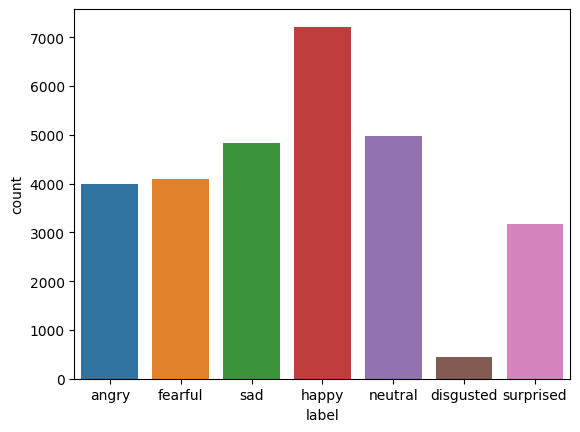

In [9]:
# df=sns.load_dataset(train)
sns.countplot(train,x='label')

# sns.countplot(train['label'])

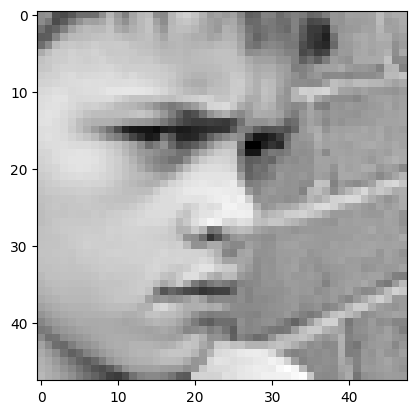

In [10]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

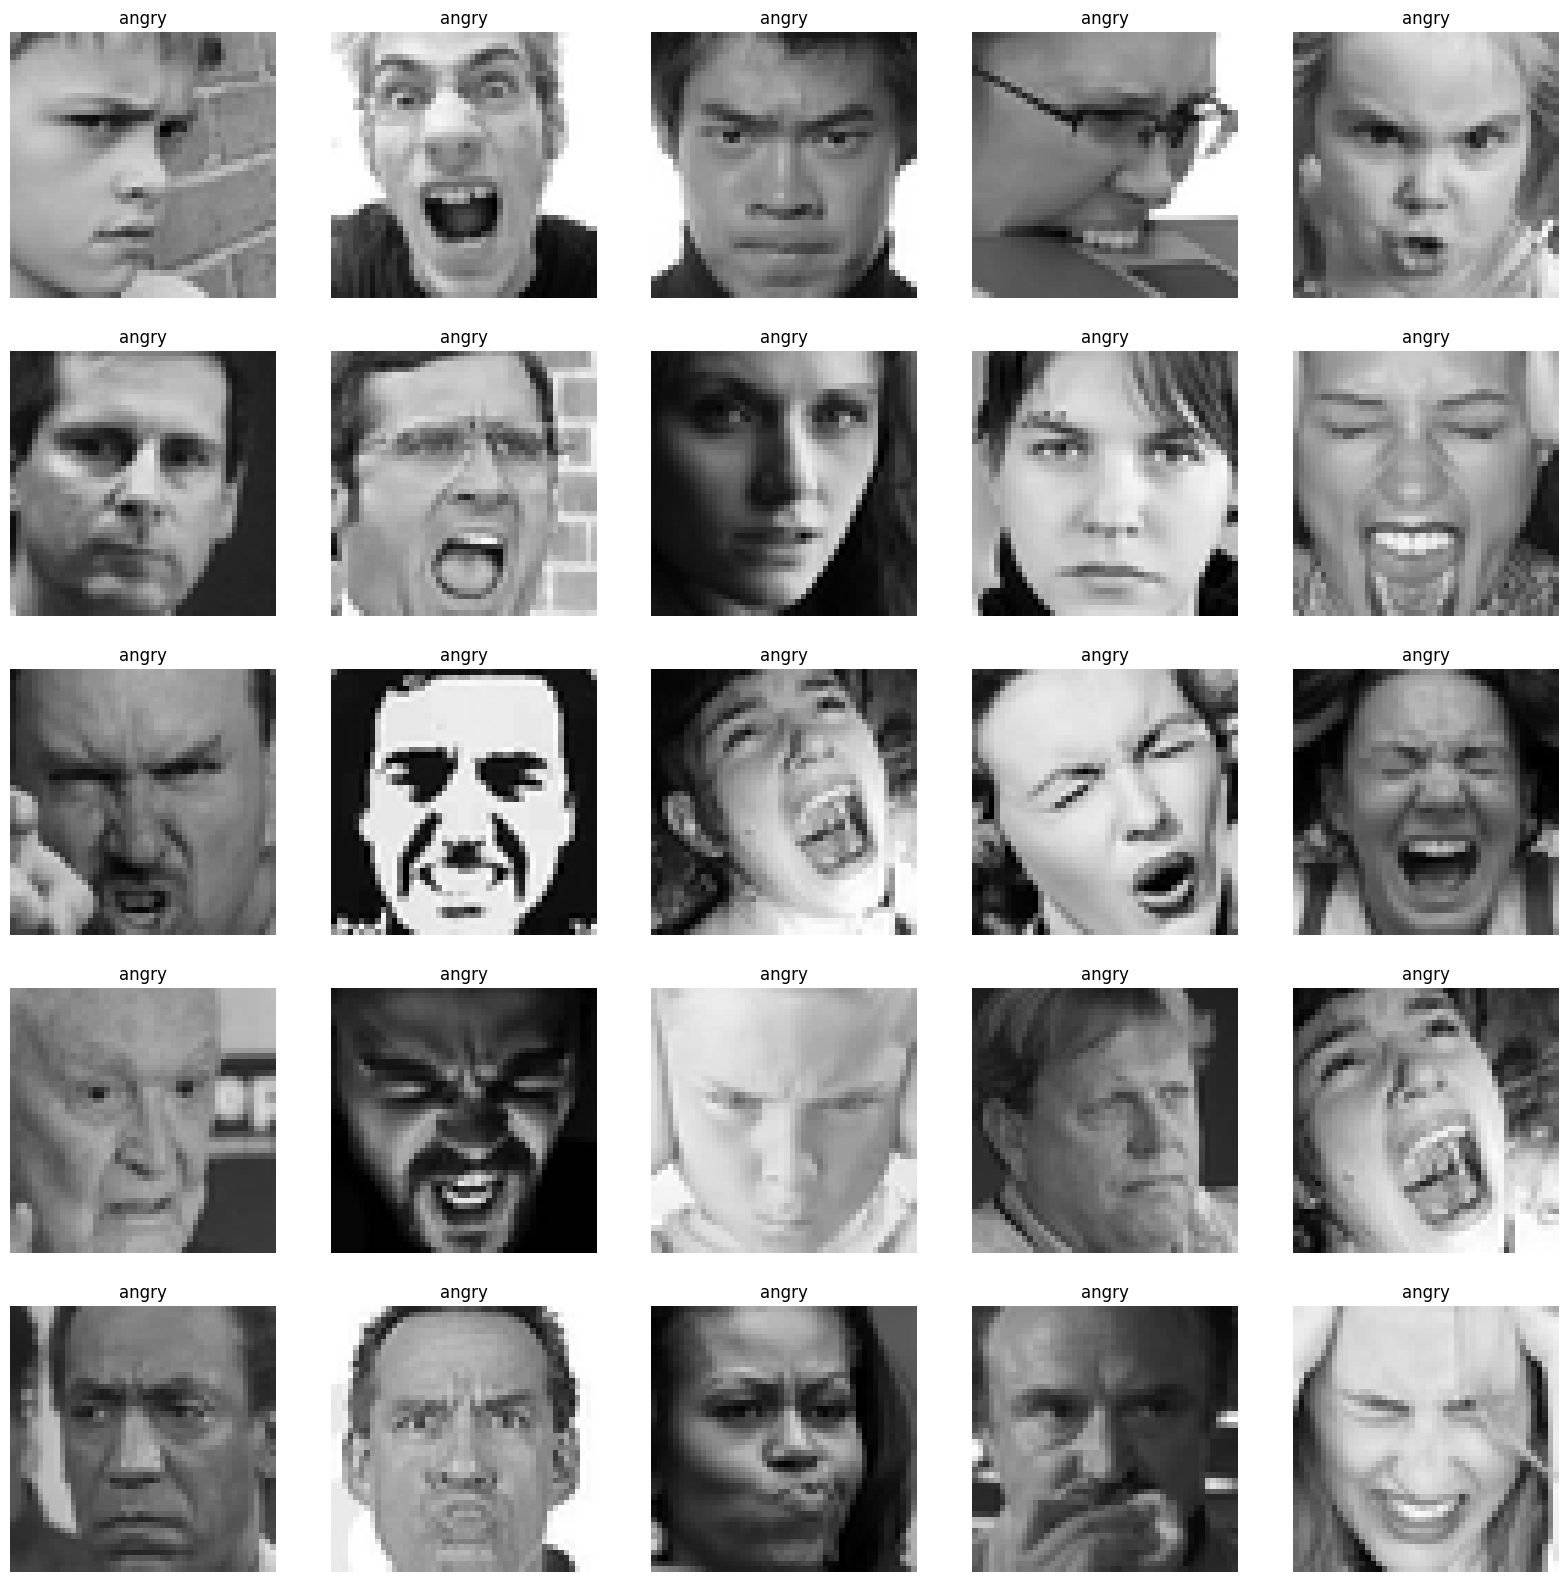

In [11]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [13]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [14]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [15]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [16]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [17]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [20]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


## Model Creation

In [21]:
with tf.device(device_name):
  model = Sequential()
  # convolutional layers
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  # fully connected layers
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  # output layer
  model.add(Dense(output_class, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [31]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 11s 51ms/step - loss: 1.2042 - accuracy: 0.5437 - val_loss: 1.1224 - val_accuracy: 0.5751
Epoch 2/100
225/225 [==============================] - 11s 50ms/step - loss: 1.1997 - accuracy: 0.5468 - val_loss: 1.1202 - val_accuracy: 0.5762
Epoch 3/100
225/225 [==============================] - 11s 50ms/step - loss: 1.1952 - accuracy: 0.5502 - val_loss: 1.1085 - val_accuracy: 0.5777
Epoch 4/100
225/225 [==============================] - 11s 50ms/step - loss: 1.1835 - accuracy: 0.5470 - val_loss: 1.1139 - val_accuracy: 0.5748
Epoch 5/100
225/225 [==============================] - 11s 50ms/step - loss: 1.1689 - accuracy: 0.5555 - val_loss: 1.1084 - val_accuracy: 0.5844
Epoch 6/100
225/225 [==============================] - 11s 50ms/step - loss: 1.1691 - accuracy: 0.5564 - val_loss: 1.1151 - val_accuracy: 0.5777
Epoch 7/100
225/225 [==============================] - 11s 50ms/step - loss: 1.1491 - accuracy: 0.5680 - val_loss: 1.0963 - val_ac

## Plot the Results

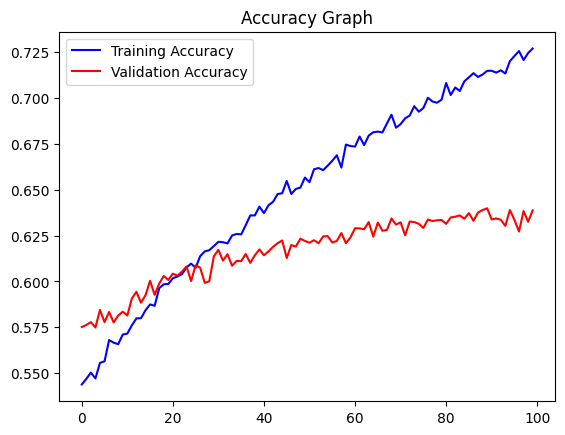

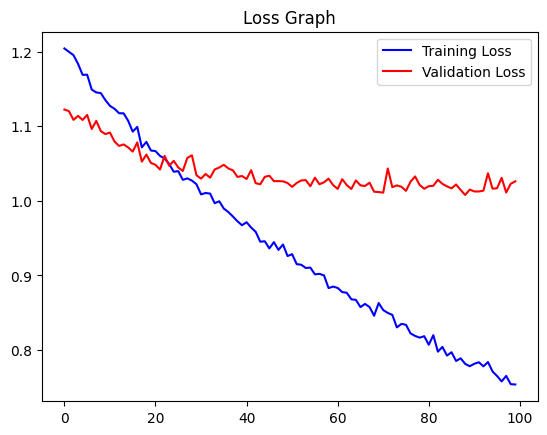

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: fearful
1/1 [==============================] - 0s 19ms/step
Predicted Output: fearful


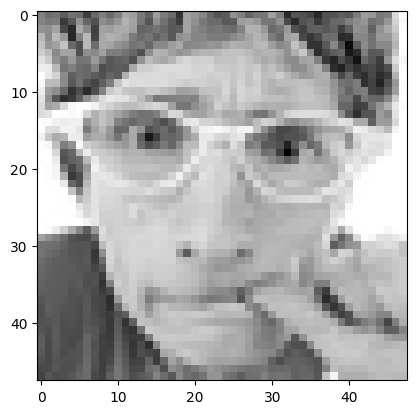

In [33]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fearful
1/1 [==============================] - 0s 19ms/step
Predicted Output: fearful


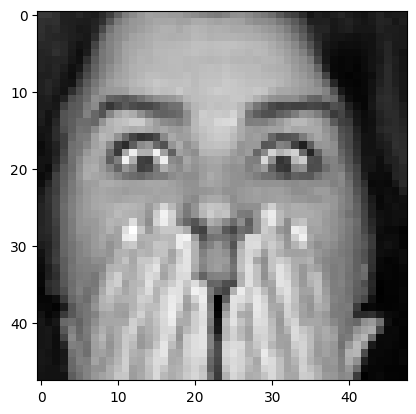

In [34]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: sad
1/1 [==============================] - 0s 21ms/step
Predicted Output: sad


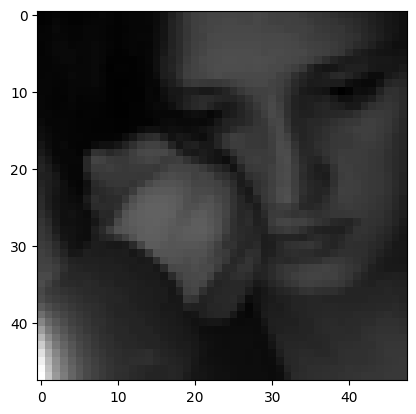

In [26]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');